In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

import os
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [2]:
n_epoch = 200
batch_size = 16
lr = 1e-4
betas = (0.9, 0.999)

input_PATH = "Data/Reduced/small_8_1k-inv.npy"
output_PATH = "Data/Reduced/small_8_1k-geoid.npy"

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Current device is ",device)


# Fit the MinMaxScalar for output data
output_for_Scalar = np.load(output_PATH)
scaler = MinMaxScaler()
scaler.fit(output_for_Scalar)
print("Fit the output range to [0,1] using MinMaxscaler")


'''
# Fit another MinMaxScalar for input data
input_for_Scalar = np.load(input_PATH)
scaler_input = StandardScaler()
scaler_input.fit(input_for_Scalar)
print("Fit the input range to [0,1] using MinMaxscaler")
'''

# make results determinstic
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Current device is  cpu
Fit the output range to [0,1] using MinMaxscaler


In [3]:
class KMNIST(Dataset):
    
    def __init__(self, input_path, output_path):
        # Load the input and output
        input_data = np.load(input_path)
        output_data = scaler.transform(np.load(output_path))
        
        self.input = input_data
        self.output = output_data
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_item = self.input[index]
        output_item = self.output[index]
        
        return input_item, output_item

In [4]:
testingAndValidation_split = 0.2
validation_split = 0.1

# Load the input and output as a complete dataset

geoid_dataset = KMNIST(
    input_PATH,
    output_PATH,
)


# Creating data indices for training, testing and validation splits
# Reference: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
geoid_dataset_size = len(geoid_dataset)
geoid_indices = list(range(geoid_dataset_size))

geoid_training_testing_split = int(np.floor(testingAndValidation_split * geoid_dataset_size))
geoid_testing_validation_split = int(np.floor(validation_split * geoid_dataset_size))

np.random.shuffle(geoid_indices)
geoid_train_indices, geoid_val_indices ,geoid_test_indices = geoid_indices[geoid_training_testing_split:], geoid_indices[:geoid_testing_validation_split], geoid_indices[geoid_testing_validation_split:geoid_training_testing_split] 

# Creating data samplers
geoid_train_sampler = SubsetRandomSampler(geoid_train_indices)
geoid_test_sampler = SubsetRandomSampler(geoid_test_indices)
geoid_valid_sampler = SubsetRandomSampler(geoid_val_indices)

geoid_train_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_train_sampler,
)

geoid_test_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_test_sampler,
)

geoid_validation_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_valid_sampler,
)

'''

generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset, validation_dataset = random_split(geoid_dataset, [0.8,0.1,0.1], generator = generator)

geoid_train_loader = DataLoader(
    dataset=train_dataset,
    batch_size = batch_size,
    shuffle = True
)

geoid_test_loader = DataLoader(
    dataset=test_dataset,
    batch_size = batch_size,
    shuffle = False
)

geoid_validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size = batch_size,
    shuffle = False
)

'''

print("Training data, testing data and validation data is spilt into 8:1:1")

Training data, testing data and validation data is spilt into 8:1:1


In [5]:
'''
train_input, train_output = next(iter(geoid_train_loader))

print(f"Feature batch shape: {train_input.size()}")
print(f"Labels batch shape: {train_output.size()}")

test_index = 1
train_input_batch_sample = train_input[test_index]
train_output_batch_sample = train_output[test_index]

print(f"Input: {train_input_batch_sample}")
print(f"Output: {train_output_batch_sample}")
'''

'\ntrain_input, train_output = next(iter(geoid_train_loader))\n\nprint(f"Feature batch shape: {train_input.size()}")\nprint(f"Labels batch shape: {train_output.size()}")\n\ntest_index = 1\ntrain_input_batch_sample = train_input[test_index]\ntrain_output_batch_sample = train_output[test_index]\n\nprint(f"Input: {train_input_batch_sample}")\nprint(f"Output: {train_output_batch_sample}")\n'

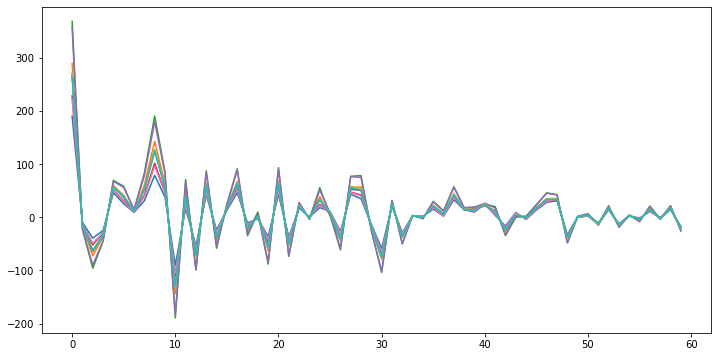

In [6]:
voutput = np.load(output_PATH)

nmodels, _ = voutput.shape

plt.figure(figsize=(12, 6))

# Just plot every 100th model output and output to observe the pattern
for i in range(1, nmodels, 100):

    plt.plot(voutput[i, :])

plt.show()

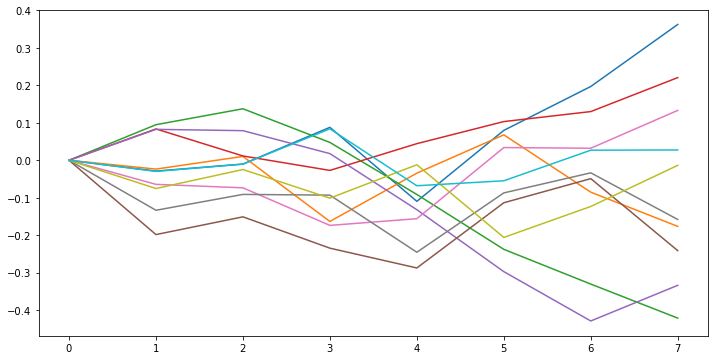

In [7]:
vinput = np.load(input_PATH)

nmodels, _ = vinput.shape

plt.figure(figsize=(12, 6))

# Just plot every 100th model input and output to observe the pattern
for i in range(1, nmodels, 100):

    plt.plot(vinput[i, :])

plt.show()

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()    
        self.fc1 = nn.Linear(8, 20)
        
        self.fc2 = nn.Linear(20, 30)   
        self.fc3 = nn.Linear(30, 60)
        
        self.relu = nn.ReLU()
        self.drop = nn.Dropout()
    
    def forward(self, x):                              
        x = x.to(torch.float32)
        
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        
        return out

In [9]:
def train(model, train_loader, val_loader, device, optimizer, n_epoch):
    
    criterion = nn.MSELoss()
    
    minimum_validation_loss = 10000000
    best_model_index = -1
    
    running_loss_list = []
    validation_loss_list = []

    # n_epoch times of iterations
    for epoch in range(n_epoch):

        running_loss = 0.0

        model.train()
        
        for data in train_loader:
            # get a batch of inputs and labels
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # Get output features, calculate loss and optimize
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
            
            loss.backward()
            optimizer.step()

            # Add to the total training loss
            running_loss += loss.item()

        # print some statistics
        print(epoch+1,"epochs have finished")
        print("Current training loss is ",running_loss)
        running_loss_list.append(running_loss)
        running_loss = 0.0

        # Valiadation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            valid_loss = 0.0
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                
                # Get output features and calculate loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # If the loss value is less than 0.02, we consider it being accurate
                for j in range(len(labels)):
                    single_loss = criterion(outputs[j], labels[j])
                    if single_loss.item() <= 0.01:
                        correct += 1
                    total += 1

                # Add to the validation loss
                valid_loss += loss.item()

            # Calculate valiadation accuracy and print Validation statistics
            print("Validation loss for this epoch is",valid_loss)
            print("Validation Accuracy for this epoch is", 100*correct//total)
            validation_loss_list.append(valid_loss)

        # Update the statistics for the best model
        if valid_loss <= minimum_validation_loss:
            minimum_validation_loss = valid_loss

            # Store the best models
        
            PATH = 'geoid_model_best.pth'

            torch.save(model.state_dict(), PATH)
            print("This model is now saved to Path:",PATH)
            
            best_model_index = epoch
            
        print()
    
    # Training finished, print the statistics for the best model
    print('Finished Training')
    print("Best model has a validation loss of ",minimum_validation_loss)
    print("Best model is in epoch ",best_model_index+1)
    
    # Plot the Training loss and validation loss during training
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(running_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss in each epoch')

    plt.subplot(2, 1, 2)
    plt.plot(validation_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss in each epoch')
    
    plt.subplots_adjust(hspace=1)

    plt.show()

In [10]:
model = Net().to(device)
#optimizer = Minimizer(model.parameters(), method='bfgs', disp=2, max_iter = 2)
#optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

1 epochs have finished
Current training loss is  16.06066742539406
Validation loss for this epoch is 2.2429737124136833
Validation Accuracy for this epoch is 0
This model is now saved to Path: geoid_model_best.pth

2 epochs have finished
Current training loss is  15.357973575592041
Validation loss for this epoch is 2.109602493510198
Validation Accuracy for this epoch is 0
This model is now saved to Path: geoid_model_best.pth

3 epochs have finished
Current training loss is  14.583074629306793
Validation loss for this epoch is 2.0471245972128576
Validation Accuracy for this epoch is 0
This model is now saved to Path: geoid_model_best.pth

4 epochs have finished
Current training loss is  13.671264320611954
Validation loss for this epoch is 1.8687453988329366
Validation Accuracy for this epoch is 0
This model is now saved to Path: geoid_model_best.pth

5 epochs have finished
Current training loss is  12.593125894665718
Validation loss for this epoch is 1.7269490116365778
Validation Accura

41 epochs have finished
Current training loss is  0.4662653156556189
Validation loss for this epoch is 0.06905062789872997
Validation Accuracy for this epoch is 66
This model is now saved to Path: geoid_model_best.pth

42 epochs have finished
Current training loss is  0.4389453842304647
Validation loss for this epoch is 0.06114447217632761
Validation Accuracy for this epoch is 67
This model is now saved to Path: geoid_model_best.pth

43 epochs have finished
Current training loss is  0.41236244328320026
Validation loss for this epoch is 0.06504935108181462
Validation Accuracy for this epoch is 69

44 epochs have finished
Current training loss is  0.3897503246553242
Validation loss for this epoch is 0.052063454193496644
Validation Accuracy for this epoch is 71
This model is now saved to Path: geoid_model_best.pth

45 epochs have finished
Current training loss is  0.37014289759099483
Validation loss for this epoch is 0.05323116353270298
Validation Accuracy for this epoch is 71

46 epochs 

Validation loss for this epoch is 0.016747083151083517
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

85 epochs have finished
Current training loss is  0.12469975335989147
Validation loss for this epoch is 0.01853967702958984
Validation Accuracy for this epoch is 100

86 epochs have finished
Current training loss is  0.12099343223962933
Validation loss for this epoch is 0.016705670237900695
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

87 epochs have finished
Current training loss is  0.11707634676713496
Validation loss for this epoch is 0.015939686480906858
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

88 epochs have finished
Current training loss is  0.11337496631313115
Validation loss for this epoch is 0.016367642954628253
Validation Accuracy for this epoch is 100

89 epochs have finished
Current training loss is  0.10970925691071898

128 epochs have finished
Current training loss is  0.04037799430079758
Validation loss for this epoch is 0.005735619781469547
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

129 epochs have finished
Current training loss is  0.039874077949207276
Validation loss for this epoch is 0.005353830636641714
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

130 epochs have finished
Current training loss is  0.03938896197360009
Validation loss for this epoch is 0.0056393169346077325
Validation Accuracy for this epoch is 100

131 epochs have finished
Current training loss is  0.03889714114484377
Validation loss for this epoch is 0.00528372678058614
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

132 epochs have finished
Current training loss is  0.03842951683327556
Validation loss for this epoch is 0.005088347533106258
Validation Accuracy for this epoch 

Validation loss for this epoch is 0.0033837301063445427
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

171 epochs have finished
Current training loss is  0.025440812984015793
Validation loss for this epoch is 0.003509932602599558
Validation Accuracy for this epoch is 100

172 epochs have finished
Current training loss is  0.025219429342541844
Validation loss for this epoch is 0.003641676246579603
Validation Accuracy for this epoch is 100

173 epochs have finished
Current training loss is  0.02494439820293337
Validation loss for this epoch is 0.0036564875702090943
Validation Accuracy for this epoch is 100

174 epochs have finished
Current training loss is  0.024720212997635826
Validation loss for this epoch is 0.003737487638367363
Validation Accuracy for this epoch is 100

175 epochs have finished
Current training loss is  0.024481032829498872
Validation loss for this epoch is 0.0034174549447346485
Validation Accuracy for this epoch is 1

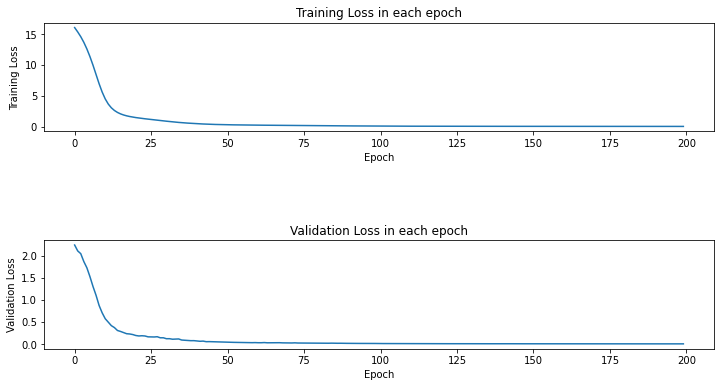

'\ncriterion = nn.MSELoss()\n\ndef closure():\n    for data in geoid_train_loader:\n        # get a batch of inputs and labels\n        inputs, labels = data[0].to(device), data[1].to(device)\n        \n    optimizer.zero_grad()\n    output = model(inputs)\n    loss = criterion(output.float(), labels.float())\n    \n    return loss\n\nloss = optimizer.step(closure)\nprint(loss.item())\n'

In [11]:
train(model, geoid_train_loader, geoid_validation_loader, device, optimizer, n_epoch)
'''
criterion = nn.MSELoss()

def closure():
    for data in geoid_train_loader:
        # get a batch of inputs and labels
        inputs, labels = data[0].to(device), data[1].to(device)
        
    optimizer.zero_grad()
    output = model(inputs)
    loss = criterion(output.float(), labels.float())
    
    return loss

loss = optimizer.step(closure)
print(loss.item())
'''

In [12]:
def test(model, test_loader, device):

    # Load the model from the input model_path  
    #model.load_state_dict(torch.load(model_path))

    correct = 0
    total = 0
    criterion = nn.MSELoss()
    total_loss = 0.0
    
    best_worst_error_list = [1000000, 0]
    best_worst_input_list = [0, 0]
    best_worst_output_list = [0, 0]
    best_worst_predicted_list = [0, 0]
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
                
            # Get output features and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                
            # If the loss value is less than 0.02, we consider it being accurate
            for j in range(len(labels)):
                single_loss = criterion(outputs[j], labels[j])
                if single_loss.item() <= 0.01:
                    correct += 1
                total += 1
                
                # Record worst error
                if single_loss.item() > best_worst_error_list[1]:
                    best_worst_error_list[1] = single_loss.item()
                    best_worst_input_list[1] = inputs[j]
                    best_worst_output_list[1] = labels[j]
                    best_worst_predicted_list[1] = outputs[j]
                    
                # Record best error
                if single_loss.item() < best_worst_error_list[0]:
                    best_worst_error_list[0] = single_loss.item()
                    best_worst_input_list[0] = inputs[j]
                    best_worst_output_list[0] = labels[j]
                    best_worst_predicted_list[0] = outputs[j]
                    

            # Add to the validation loss
            total_loss += loss.item()

    # Calculate the overall accuracy and return the accuracy and test loss
    print("Total loss for the model is",total_loss)
    print("Accuracy for the model is", 100*correct//total)
    print()
    
    # Draw some plots for the best and the worst error
    print("Best model has a error of ", best_worst_error_list[0])
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case input")
    plt.plot(best_worst_input_list[0].detach().numpy())

    plt.show()
    
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case plot")
    plt.plot(scaler.inverse_transform([best_worst_output_list[0].detach().numpy()])[0], label='Data Output')
    plt.plot(scaler.inverse_transform([best_worst_predicted_list[0].detach().numpy()])[0], label='Predicted Output')
    plt.legend()

    plt.show()
    
    
    print("Worst model has a error of ", best_worst_error_list[1])
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case input")
    plt.plot(best_worst_input_list[1].detach().numpy())

    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case plot")
    plt.plot(scaler.inverse_transform([best_worst_output_list[1].detach().numpy()])[0], label='Data Output')
    plt.plot(scaler.inverse_transform([best_worst_predicted_list[1].detach().numpy()])[0], label='Predicted Output')
    plt.legend()

    plt.show()
    
    #return 100*correct//total, total_loss

Total loss for the model is 0.01913332805566639
Accuracy for the model is 100

Best model has a error of  2.4849276243359315e-05


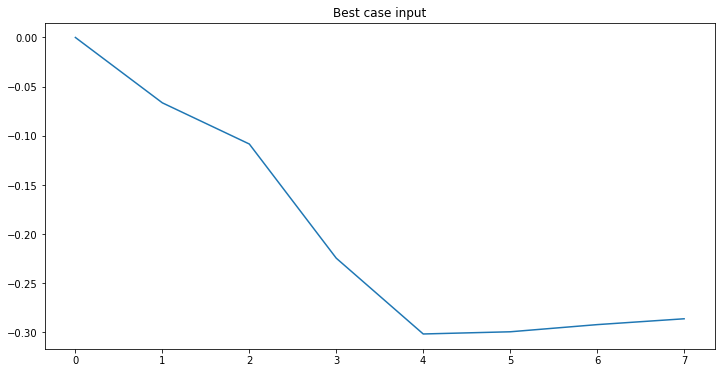

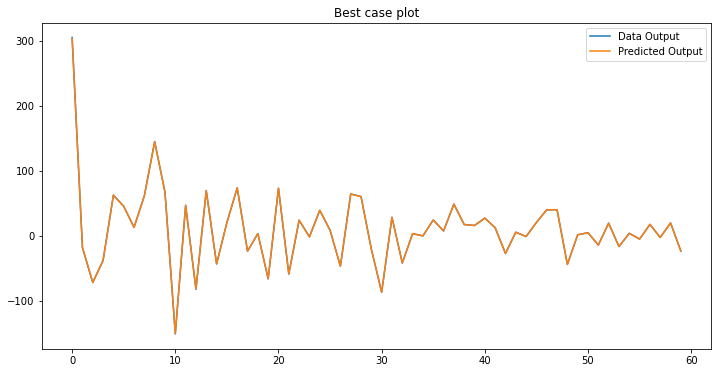

Worst model has a error of  0.0017904826071100121


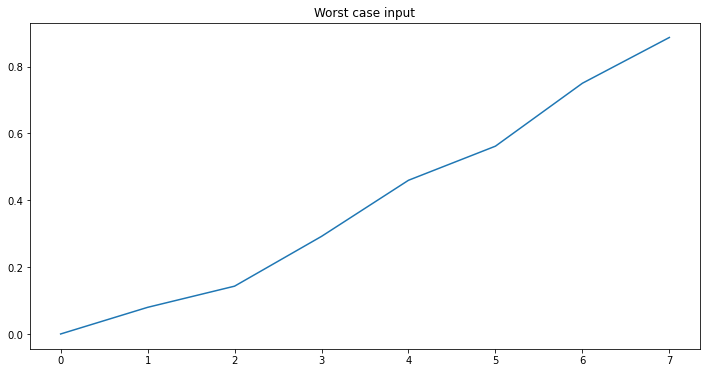

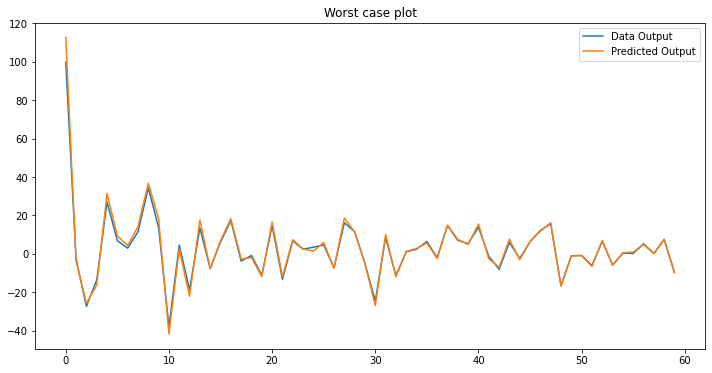

In [13]:
# Print Accuracy for the training data using the current model (Not the best one)
test(model, geoid_train_loader, device)

Total loss for the model is 0.002652212453401993
Accuracy for the model is 100

Best model has a error of  4.716378594826568e-05


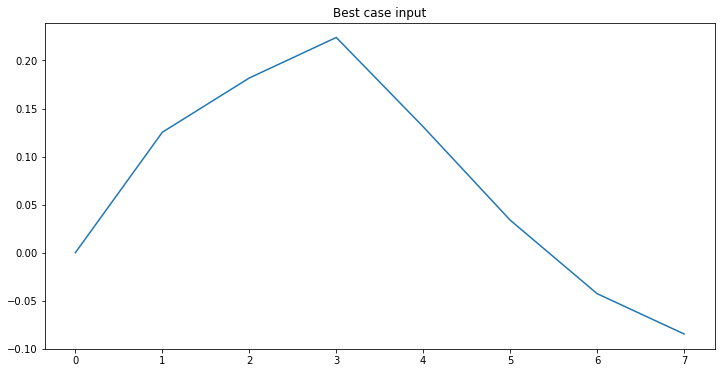

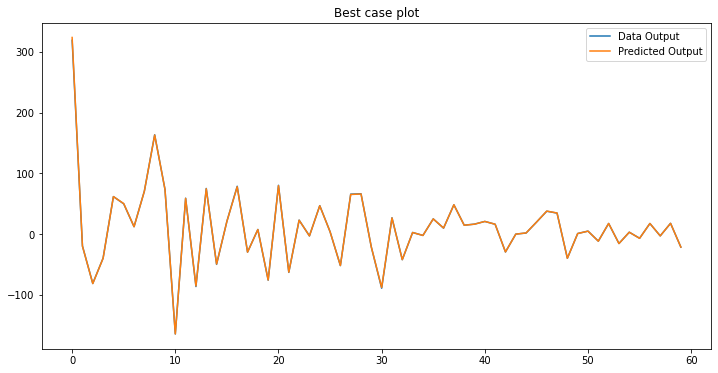

Worst model has a error of  0.0019919832401808233


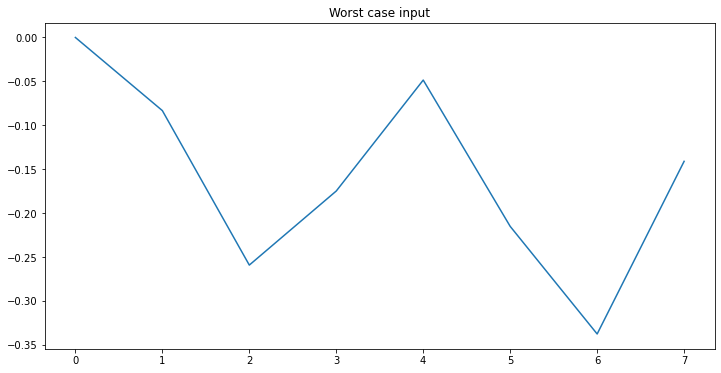

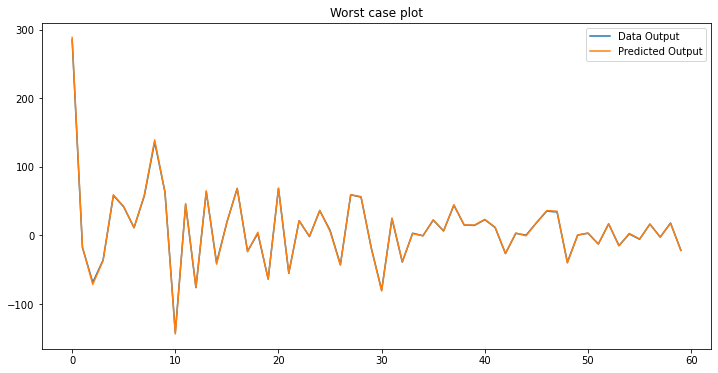

In [14]:
# Print Accuracy for the Testing data using the current model (Not the best one)
test(model, geoid_test_loader, device)

Total loss for the model is 0.01913332805566638
Accuracy for the model is 100

Best model has a error of  2.4849276243359315e-05


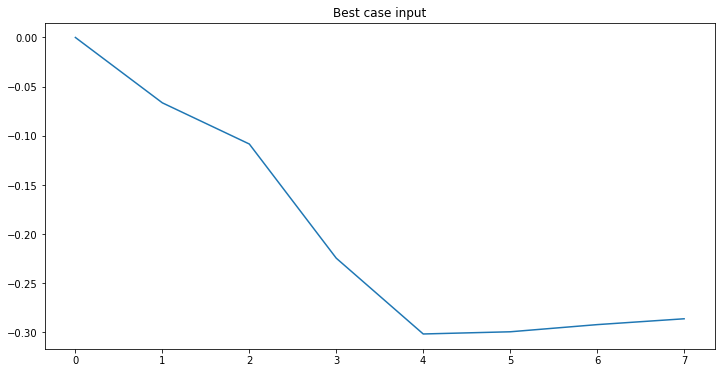

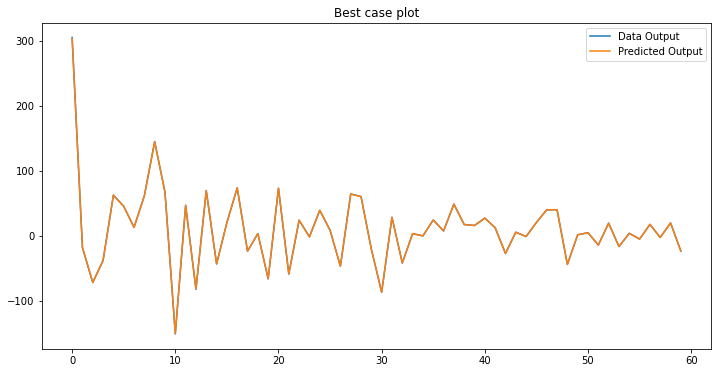

Worst model has a error of  0.0017904826071100121


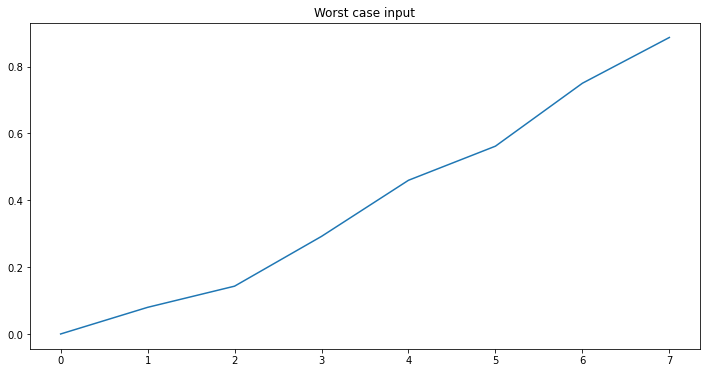

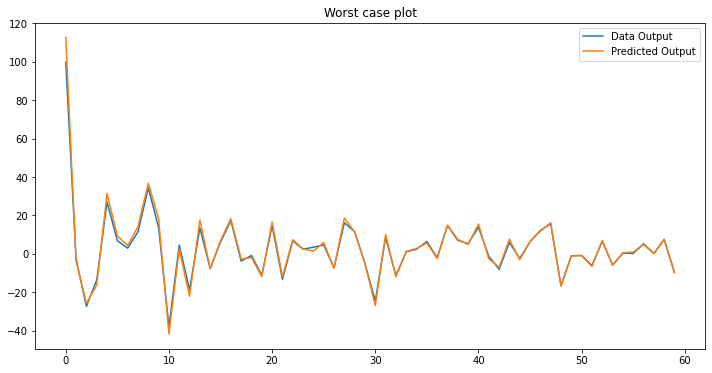

In [15]:
# Print Accuracy for the training data using the best one
model.load_state_dict(torch.load('geoid_model_best.pth'))
test(model, geoid_train_loader, device)

Total loss for the model is 0.0026710757104823845
Accuracy for the model is 100

Best model has a error of  4.716378594826568e-05


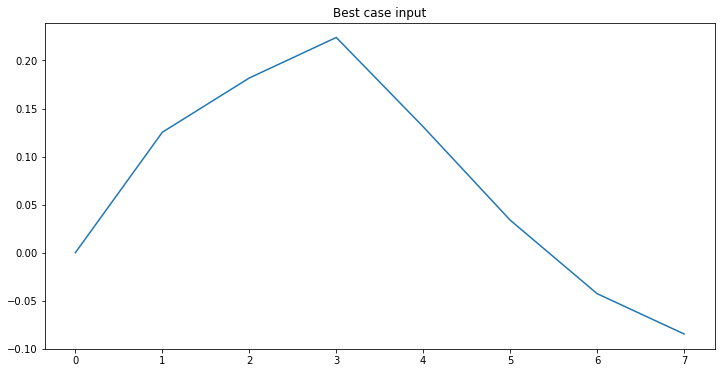

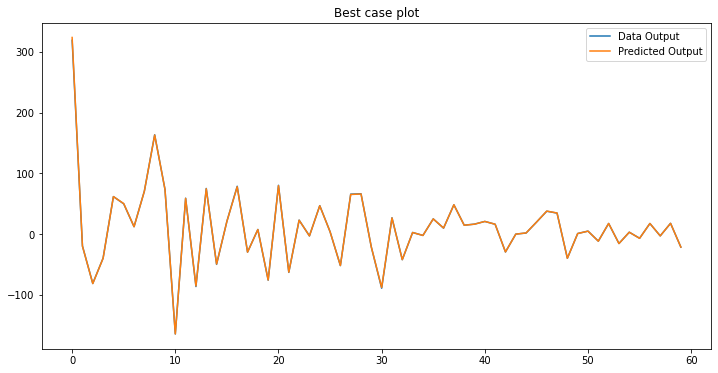

Worst model has a error of  0.0019919832401808233


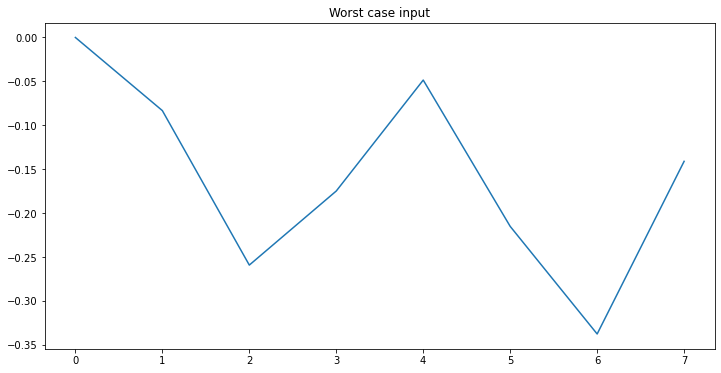

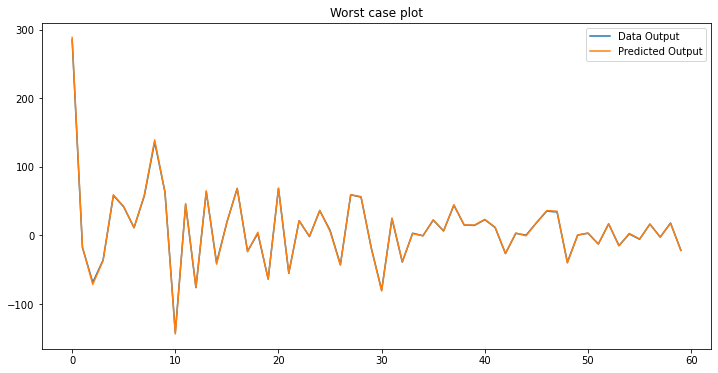

In [16]:
# Print Accuracy for the Testing data using the Best model
test(model, geoid_test_loader, device)

Loss between predicted output and actual output (Both Normalised) 0.0005962874708386501


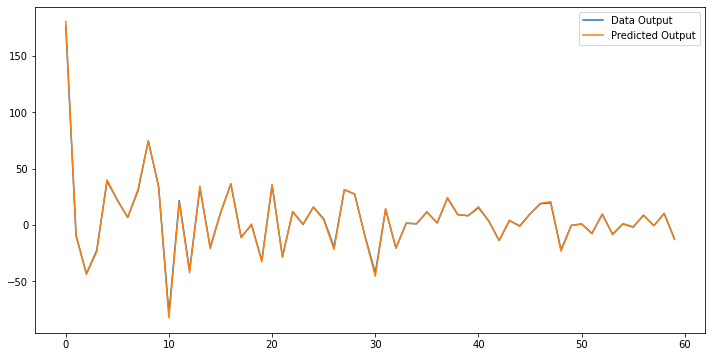

Loss between predicted output and actual output (Both Normalised) 0.0005999055284455575


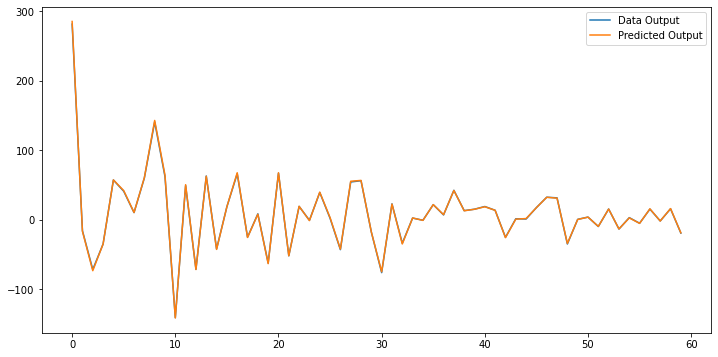

Loss between predicted output and actual output (Both Normalised) 0.00017664190683692075


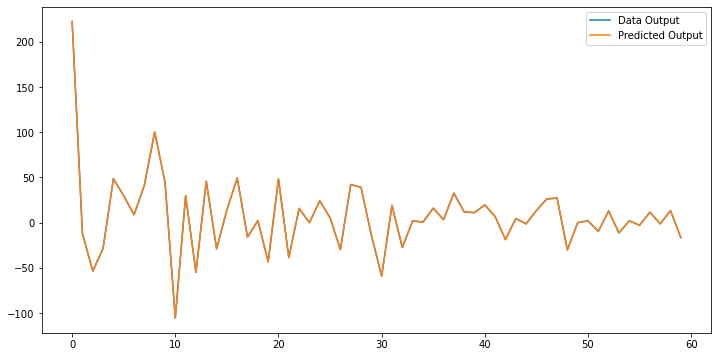

Loss between predicted output and actual output (Both Normalised) 0.00012459022654504086


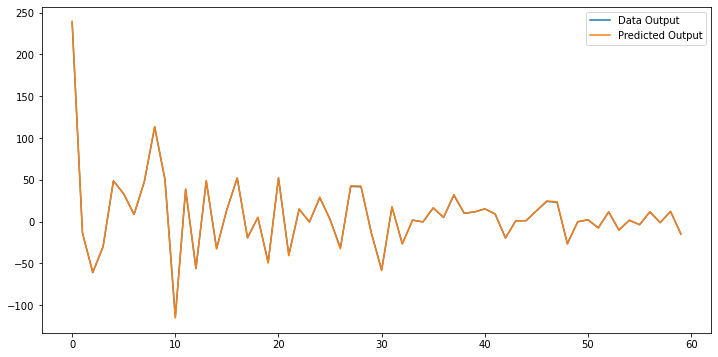

Loss between predicted output and actual output (Both Normalised) 6.884331191866709e-05


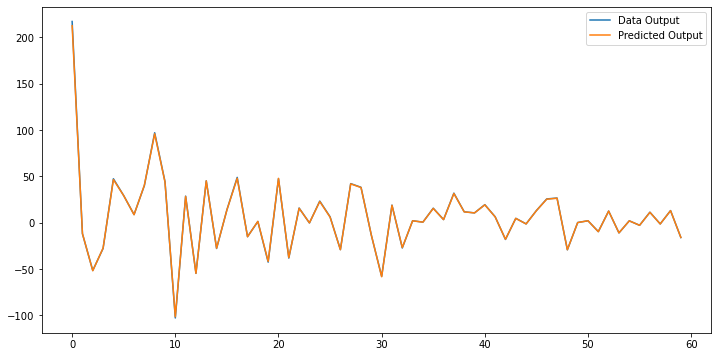

Loss between predicted output and actual output (Both Normalised) 0.0002066632476371954


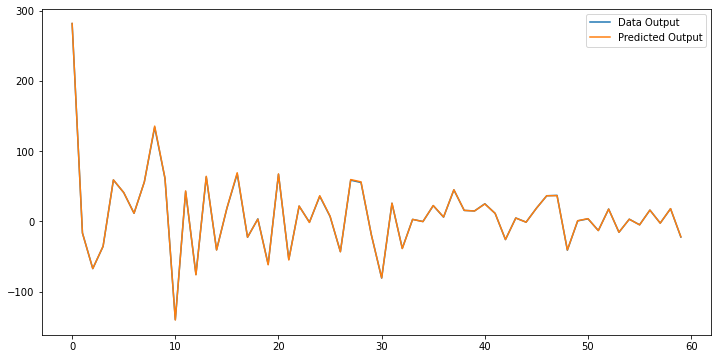

Loss between predicted output and actual output (Both Normalised) 0.0001554394421712056


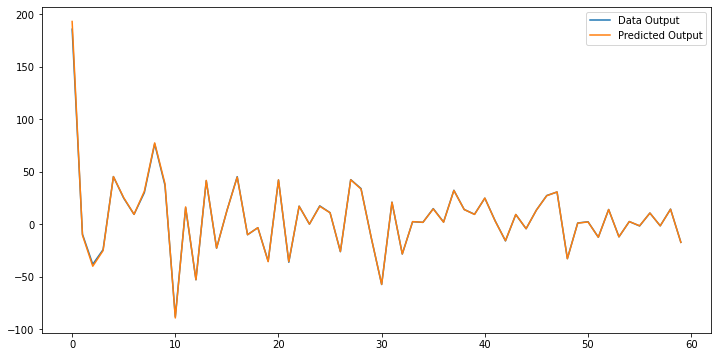

Loss between predicted output and actual output (Both Normalised) 0.0003258869987291541


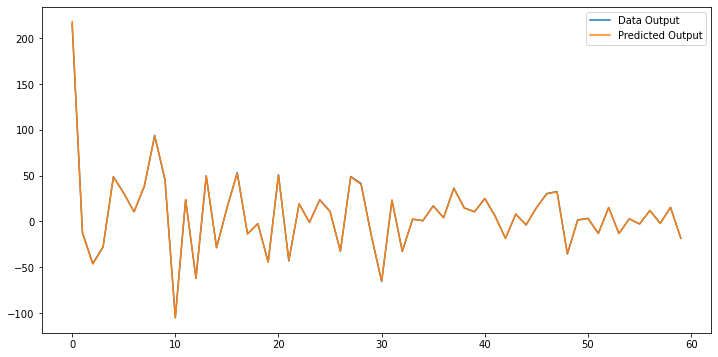

Loss between predicted output and actual output (Both Normalised) 0.0007606613702399644


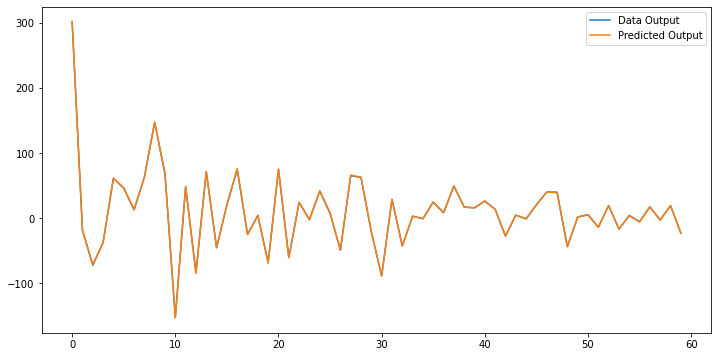

Loss between predicted output and actual output (Both Normalised) 0.00019817936122283752


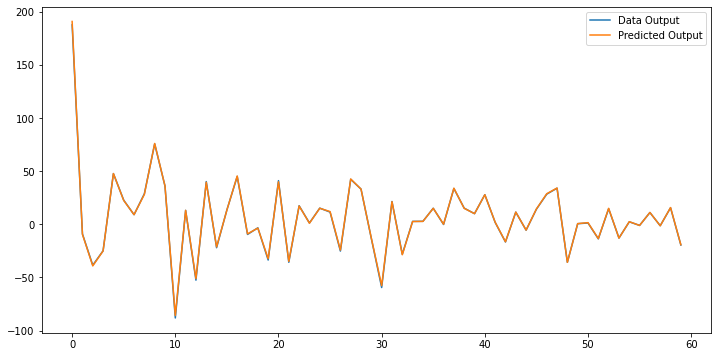

Loss between predicted output and actual output (Both Normalised) 0.0001285620703250969


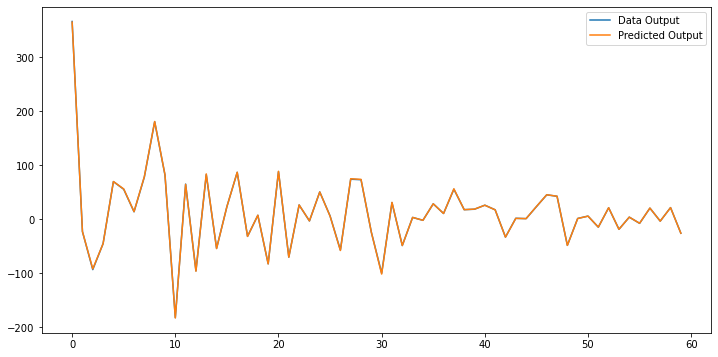

Loss between predicted output and actual output (Both Normalised) 0.000269414936972992


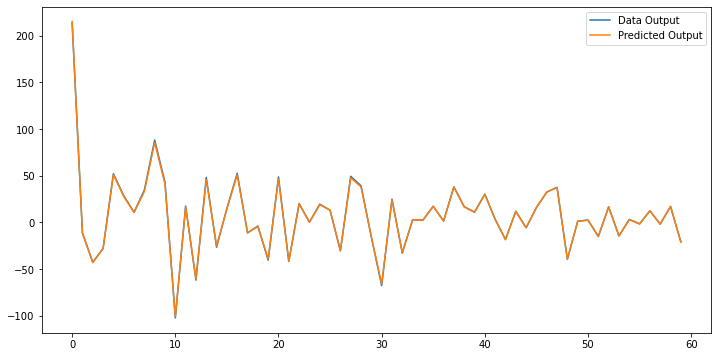

Loss between predicted output and actual output (Both Normalised) 0.0008630145930025215


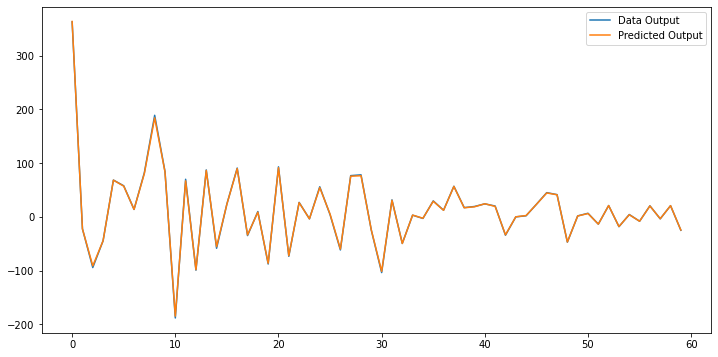

Loss between predicted output and actual output (Both Normalised) 0.0001955247658555222


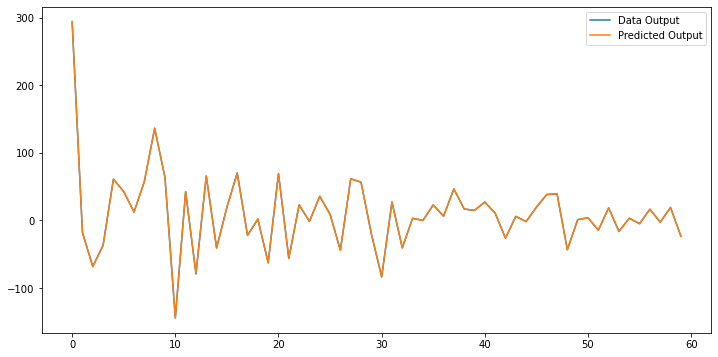

Loss between predicted output and actual output (Both Normalised) 0.000793411104495433


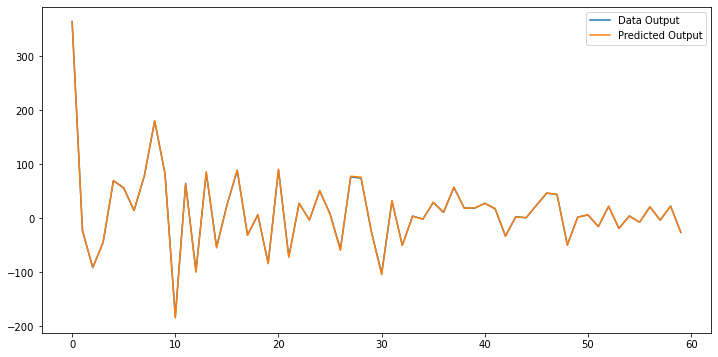

Loss between predicted output and actual output (Both Normalised) 0.0006673645669874115


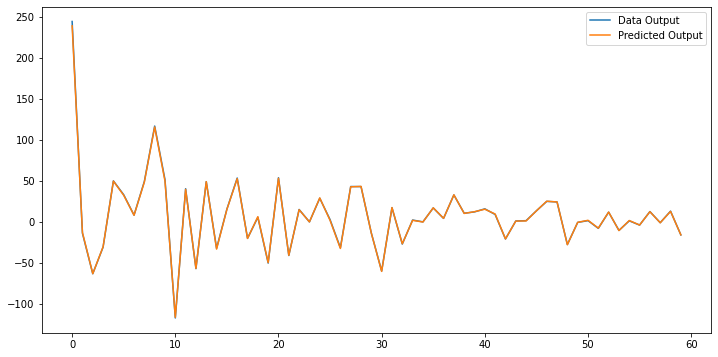

In [17]:
# Testing for a complete batch in the test dataset using the best model

model.load_state_dict(torch.load('geoid_model_best.pth'))
testing_criterion = nn.MSELoss()

test_input, test_output = next(iter(geoid_test_loader))
for i in range(batch_size):    
    test_index = i
    test_input_batch_sample = test_input[test_index]
    test_output_batch_sample = test_output[test_index]
    predicted_output = model(test_input_batch_sample)
    
    loss = testing_criterion(test_output_batch_sample, predicted_output)
    print("Loss between predicted output and actual output (Both Normalised)",loss.item())
    
    #print(scaler.inverse_transform([predicted_output.detach().numpy()])[0])
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(scaler.inverse_transform([test_output_batch_sample.detach().numpy()])[0], label='Data Output')
    plt.plot(scaler.inverse_transform([predicted_output.detach().numpy()])[0], label='Predicted Output')
    plt.legend()

    plt.show()

In [18]:
'''
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)
'''

'\nfor name, param in model.named_parameters():\n    if param.requires_grad:\n        print (name, param.data)\n'